In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("..")
sys.path.append("../..")

In [2]:
import os
import json
import numpy as np
import pandas as pd
from explorer.utils import load_states_from_dir
import matplotlib.pyplot as plt
%env OPENAI_API_KEY="g"

2024-02-01 19:10:19.624 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager


env: OPENAI_API_KEY="g"


In [3]:
from games.ultimatum.ultimatum_multi_turn.game import MultiTurnUltimatumGame

# backward compatability
class UltimatumGame(MultiTurnUltimatumGame):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

log_dir = ".logs/ultimatum_3_period"
log_dir_one_shot = ".logs/ultimatum_one_shot"
game_states = load_states_from_dir(log_dir) #+ load_states_from_dir(log_dir) 
game_states_one_shot = load_states_from_dir(log_dir_one_shot)

2024-02-01 19:10:19.926 
  command:

    streamlit run /home/vinid/.local/lib/python3.10/site-packages/ipykernel_launcher.py [ARGUMENTS]
2024-02-01 19:10:19.927 No runtime found, using MemoryCacheStorageManager


THERE ARE 220 log files
220 Loaded Successfully

Exception Type: AssertionError
Exception Message: WARNING : Game  .logs/ultimatum_one_shot/1703136869551/game_state.json has not ended

Stack Trace:
Traceback (most recent call last):
  File "/home/vinid/.local/lib/python3.10/site-packages/streamlit/runtime/caching/storage/in_memory_cache_storage_wrapper.py", line 87, in get
    entry_bytes = self._read_from_mem_cache(key)
  File "/home/vinid/.local/lib/python3.10/site-packages/streamlit/runtime/caching/storage/in_memory_cache_storage_wrapper.py", line 137, in _read_from_mem_cache
    raise CacheStorageKeyNotFoundError("Key not found in mem cache")
streamlit.runtime.caching.storage.cache_storage_protocol.CacheStorageKeyNotFoundError: Key not found in mem cache

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/vinid/.local/lib/python3.10/site-packages/streamlit/runtime/caching/cache_data_api.py", line 596, in read_result

In [4]:
def player_two_acceptance(game_states):
    run_id = [ os.path.basename(g.log_path) for g in game_states if len(g.game_state) == 4]
    decision = [ g.game_state[2]['player_public_info_dict']['player answer']for g in game_states if len(g.game_state) == 4] 
    trades = [ g.game_state[1]['player_public_info_dict']['newly proposed trade']for g in game_states if len(g.game_state) == 4] 
    # for idx, _ in enumerate(trades):
    #     print(idx, _)
    proposal_values = np.array([t.resources_from_first_agent.value() for t in trades])
    df = pd.DataFrame(list(zip(run_id, proposal_values, decision)), columns=['id', 'amount', 'decision'])
    df['amount'] = df['amount'].astype(int)
    return df

def player_one_acceptance(game_states):
    run_id = [ os.path.basename(g.log_path) for g in game_states if len(g.game_state) == 5]
    decision = [ g.game_state[3]['player_public_info_dict']['player answer']for g in game_states if len(g.game_state) == 5] 
    trades = [ g.game_state[2]['player_public_info_dict']['newly proposed trade']for g in game_states if len(g.game_state) == 5] 
    # for idx, _ in enumerate(trades):
    #     print(idx, _)
    proposal_values = np.array([t.resources_from_first_agent.value() for t in trades])
    df = pd.DataFrame(list(zip(run_id, proposal_values, decision)), columns=['id', 'amount', 'decision'])
    df['amount'] = df['amount'].astype(int)
    return df

In [15]:
df_one_shot = player_two_acceptance(game_states_one_shot)
# df_one_shot = df_one_shot[df_one_shot['decision'].isin(['ACCEPT', 'REJECT'])]
df_one_shot['decision'] = df_one_shot['decision'] == 'ACCEPT'
print(df_one_shot.tail(10))
df_one_shot= df_one_shot.groupby('amount')['decision'].agg(['mean','count'])#)mean().reset_index(name='mean')
df_one_shot.transpose()

                id  amount  decision
210  1703142301587      10      True
211  1703142335381      10      True
212  1703142363633      10     False
213  1703142393532      10      True
214  1703142417481      10      True
215  1703142456737      10      True
216  1703142486926      10      True
217  1703142802062      10      True
218  1703142841775      10      True
219  1703143115326      10      True


amount,0,1,2,3,4,5,6,7,8,9,10
mean,0.85,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.95
count,20.00,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.00


In [16]:
df = player_one_acceptance(game_states)

df['decision'] = df['decision'] == 'ACCEPT'
df= df.groupby('amount')['decision'].agg(['mean','count'])#)mean().reset_index(name='mean')
df


# df[df['amount']==6]


,mean,count
amount,,
0,0.75,20
1,1.00,20
2,1.00,20
3,1.00,20
4,1.00,20
5,0.95,20
6,0.90,20
7,0.70,20
8,0.35,20


In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_context('poster')
sns.set_palette('colorblind')

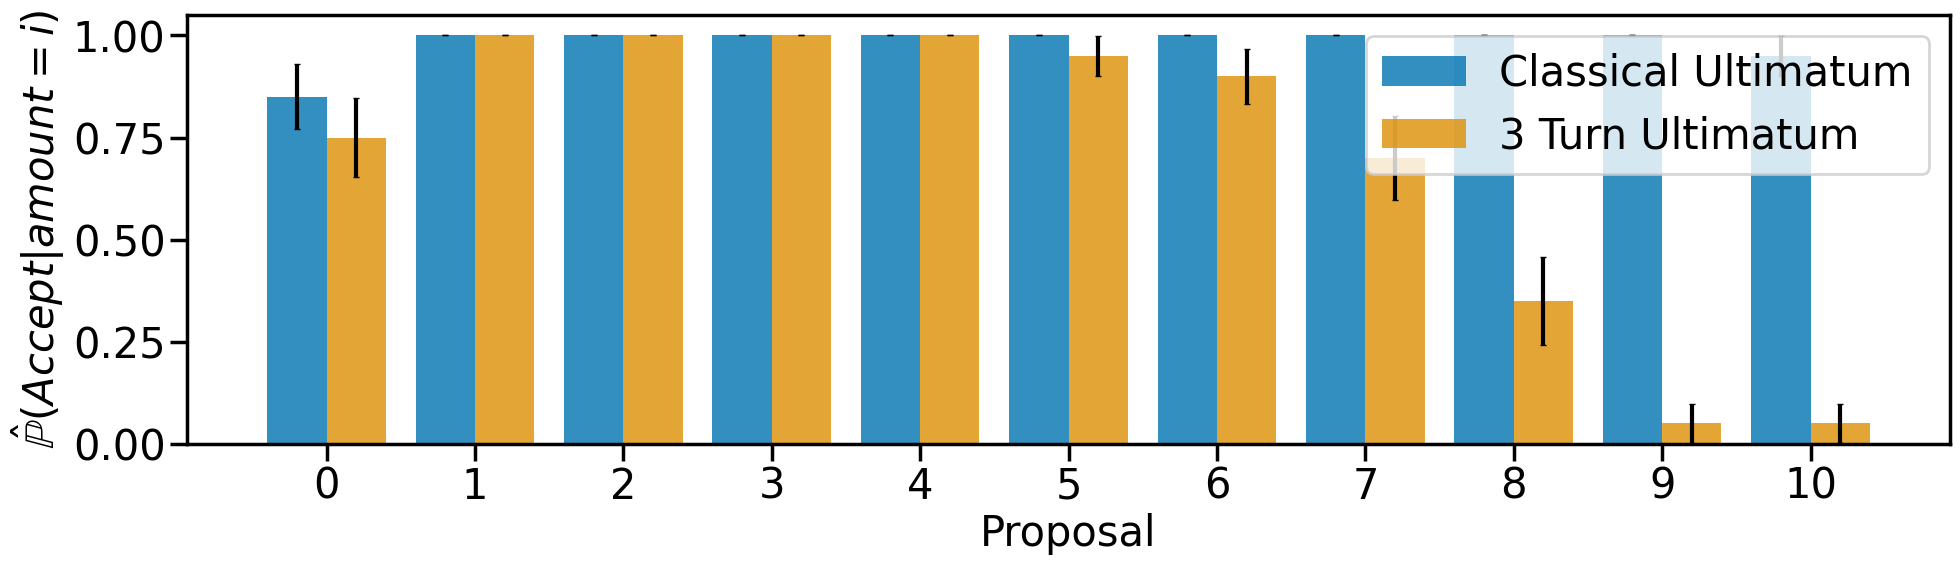

In [23]:
sd = lambda row : ( row[0]*(1-row[0]) / row[1]) ** 0.5
plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots(figsize=(20,6))

ax.bar(
    np.arange(11).astype(int)-0.2,df_one_shot['mean'],yerr=[df_one_shot.apply(sd, axis=1)],    capsize=2,    alpha=0.8,    width=0.4,    align='center')

ax.bar(
    np.arange(11).astype(int)+0.2,    df['mean'],    yerr=[df.apply(sd, axis=1)],    capsize=2,    alpha=0.8,    width=0.4,    align='center')

plt.xticks(np.arange(11), fontsize=30)

plt.yticks(np.arange(0, 1.1, 0.25), fontsize=30)
plt.xlabel('Proposal', fontsize=30)
plt.ylabel('$\hat{\mathbb{P}}(Accept|amount=i)$', fontsize=30)
plt.tight_layout()
# plt.legend(['P1 as Proposer', 'P2 as Proposer',],loc='upper right', bbox_to_anchor=(1, 1))
plt.legend(['Classical Ultimatum', '3 Turn Ultimatum',],loc='upper right', bbox_to_anchor=(1, 1), fontsize=30)


plt.tight_layout()
plt.savefig('ultimatum_acceptance_probability.pdf')  


In [9]:
# sd = lambda row : ( row[0]*(1-row[0]) / row[1]) ** 0.5
# plt.rcParams.update({'font.size': 13})
# fig, ax = plt.subplots(figsize=(10,5))
# ax.bar(
#     np.arange(21).astype(int)-0.2,
#     df_one_shot['mean'],
#     yerr=[df_one_shot.apply(sd, axis=1)],
#     capsize=2,
#     alpha=0.8,
#     width=0.4,
#     align='center')

# ax.bar(
#     np.arange(21).astype(int)+0.2,
#     df['mean'],
#     yerr=[df.apply(sd, axis=1)],
#     capsize=2,
#     alpha=0.8,
#     width=0.4,
#     align='center')

# plt.xticks(np.arange(21))
# plt.xlabel('Proposal (Amount Player 1 Gives to Player 2)')
# plt.ylabel('$P_{decider}( Accept | Proposal )$')
# plt.tight_layout()
# plt.legend(['P1 as Proposer', 'P2 as Proposer',],loc='upper right', bbox_to_anchor=(1, 1))

# plt.tight_layout()
# plt.savefig('ultimatum_acceptance_probability.pdf')  
